# Waveform Feature Engineering

ChatGPT brainstorming: https://chatgpt.com/share/671bbf0a-6bd4-8005-9c19-b69fcc874e7f

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import scipy.signal as signal
import seaborn as sns
from scipy.spatial import distance
import neurokit2 as nk
import time

In [2]:
df_info = pd.read_csv("https://api.vitaldb.net/cases")
df_ids = pd.read_csv("https://api.vitaldb.net/trks")

In [3]:
def get_data_for(tid):
    try:
        data = pd.read_csv(f"https://api.vitaldb.net/{tid}")
        arr = np.array(data['SNUADC/ECG_II'])
        time_array = np.linspace(0, np.array(data['Time'])[-1], len(data))
        return time_array, arr
    except Exception as e:
        print(f"Failed to fetch data for tid {tid}: {e}")
        return None, None 

In [4]:
data = pd.read_csv('data_icu.csv')
data.head()

,caseid,subjectid,Age,Ht,Wt,Sex,OP_time,Open,Robotic,Videoscopic,icu_days,death_inhosp,age_group,icu_length,Mahalanobis
0,55,5077,18.0,175.1,59.2,0,292.55,1,0,0,3,0,child,1,2.082258
1,264,10,0.7,64.1,8.9,1,475.00,1,0,0,38,0,child,1,2.051887
2,280,5985,0.6,42.0,5.6,1,435.00,1,0,0,15,0,child,1,2.553821
3,366,10,0.8,64.1,8.9,1,115.00,1,0,0,38,0,child,1,1.676772
4,527,4603,18.0,185.0,62.6,0,210.00,1,0,0,1,0,child,0,1.775898


In [5]:
ecg_time, ecg_data = get_data_for("cedfc6b4610363ed0ac5a4ac4a23e007bda34fe6")
fs = 500
valid_data = ecg_data[(ecg_time > 900) & (ecg_time < ecg_time[-1]-900)]
valid_time = ecg_time[(ecg_time > 900) & (ecg_time < ecg_time[-1]-900)]
small_time = valid_time[15000:30000]
small_data = valid_data[15000:30000]

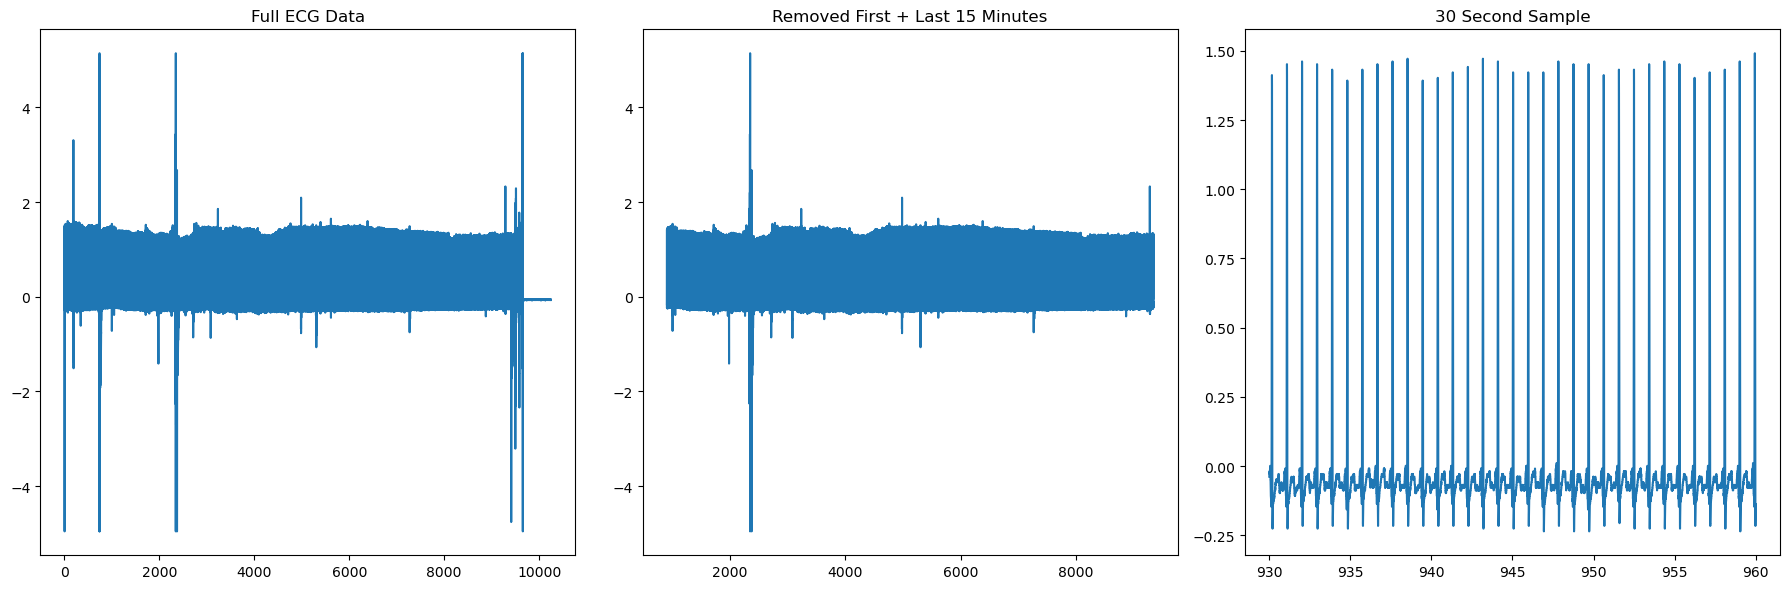

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].plot(ecg_time,ecg_data)
axs[0].set_title('Full ECG Data')
axs[1].plot(valid_time,valid_data)
axs[1].set_title('Removed First + Last 15 Minutes')
axs[2].plot(small_time,small_data)
axs[2].set_title('30 Second Sample')

plt.tight_layout()
plt.show()

# Approach 1: Sample Entropy

One idea for a feature is the *sample entropy* of the waveform. Sample Entropy is a measure of the complexity and irregularity of a time series. Essentially, it quantifies how predictable the data is over time. In a routine surgery, sample entropy for ECG data should be quite low. Higher sample entropy values indicate more complex and less predictable heart activity, while lower values suggest more regular and stable rhythms.

The original sample entropy has time complexity $O(n^2)$, which is far too slow for our very long signals. To shorten the time, we first downsampled the signal by a factor of 10 (essentially sampling at 50 Hz instead of 500 Hz) to reduce our number of data points. Then, we used segment-based sample entropy. Sample entropy compares every sample to every other sample, so by doing it in segments, we have a lot less to compare, and therefore a faster runtime. Finally, we took both the mean and the max of all of the samples, and we will see when we run this function on all of the data which one makes the most sense to use.

In [7]:
def calculate_sampen(signal, m, r):
    N = len(signal)
    
    def _phi(m):
        count = 0
        # create segments of length m
        for i in range(N - m):
            template = signal[i:i + m]
            # compare all segments to all other segments
            for j in range(i + 1, N - m):
                if np.max(np.abs(template - signal[j:j + m])) <= r:
                    count += 1
        return count / (N - m) / (N - m - 1)
    
    # formula for sample entropy
    return -np.log(_phi(m + 1) / _phi(m)) if _phi(m) > 0 else np.inf

In [8]:
def segment_based_sampen(ecg_signal, segment_length, m, r, downsample_factor=1):
    N = len(ecg_signal)
    num_segments = N // segment_length
    sampen_values = []
    
    for i in range(num_segments):
        # extract the segment
        segment = ecg_signal[i * segment_length : (i + 1) * segment_length]
        
        # downsample the segment
        if downsample_factor > 1:
            segment = segment[::downsample_factor]
        
        # calculate SampEn for the segment
        sampen_value = calculate_sampen(segment, m, r)
        sampen_values.append(sampen_value)
        
    return np.mean(sampen_values), np.max(sampen_values)

In [9]:
segment_length = 1000 # with downsampling, segments are 20 seconds
m = 2 # typical for ECG data
r = 0.2 * np.std(valid_data) # typical for ECG data
downsample_factor = 10

start_time1 = time.time()
mean_sampen, max_sampen = segment_based_sampen(valid_data, segment_length, m, r, downsample_factor)
end_time1 = time.time()

print(f"One Sample Entropy measure calculated in {end_time1 - start_time1:.3f} seconds")
print(f"Mean Sample Entropy: {mean_sampen}")
print(f"Maximum Sample Entropy: {max_sampen}")

One Sample Entropy measure calculated in 104.754 seconds
Mean Sample Entropy: 0.1555304471671046
Maximum Sample Entropy: 0.6787584431078458


This approach takes about 2 minutes for one patient, which means that even if we use the smaller dataset, it will take about 35 hours to run this for every patient.

# Approach 2: R-R intervals and RMSSD

The second method we explored for a waveform feature was related to *R-R intevals*. The waveform from ECG data is made up of three parts, known as the QRS complex. The RR interval is the time between two R peaks. Once we have the R-R intervals, we find the RMSSD, the root mean square of successive differences. This is a good measure because it is sensitive to short-term fluctuations. In this context, this means that it could accurately capture a short adverse event. According to ChatGPT, this is also a good metric because it reflects parasympathetic nervous system activity, which makes it it a good indicator of recovery potential and stress response.

Finding the R-R intervals takes a significant amount of time, and it is done with an external function, so there isn't really a way for us to make it faster. Once we have the R-R intervals, though, finding the RMSSD is easy and fast.

In [10]:
def rr_interval_rmssd(ecg_data, sampling_rate):
    ecg_cleaned = nk.ecg_clean(ecg_data, sampling_rate, method="neurokit")
    ecg_signals, ecg_info = nk.ecg_process(ecg_cleaned, sampling_rate)
    rpeaks = ecg_info['ECG_R_Peaks']
    rr_int = np.diff(rpeaks) / 500
    ma = np.convolve(rr_int, np.ones(50)/50)
    ma_sampled = [ma[15*i] for i in range(int(len(ma)/15))]
    diff = np.diff(ma_sampled)
    rmssd = np.sqrt(np.mean(diff**2))
    return rmssd

In [11]:
start_time2 = time.time()
rmssd = rr_interval_rmssd(valid_data, 500)
end_time2 = time.time()

print(f'One R-R interval measure calculated in {end_time2 - start_time2:.3f} seconds')
print(f'RMSSD: {rmssd}')

One R-R interval measure calculated in 31.667 seconds
RMSSD: 0.02963239484059367


This approach takes about 0.5 minutes for one patient, which means that even if we use the smaller dataset, it will take about 9 hours to run this for every patient.

# Comparing Patients

We want only measurements from patients in our dataset. We also had to remove 6 surgeries because they did not have ECG data, leaving us with 1136 instances.

In [12]:
patient_ecgs = df_ids[(df_ids['tname']=='SNUADC/ECG_II') & (df_ids['caseid'].isin(data['caseid']))]
patient_ecgs.head()

,caseid,tname,tid
279,4,SNUADC/ECG_II,be29325ee538657798f5c804bf72596fb3fd47ea
366,5,SNUADC/ECG_II,3431cd35ca4bc15b6de13e4c49b2db56e6bc5a37
521,7,SNUADC/ECG_II,f5bdb6cceb16a2f45ad0df54d3736126d7d076bd
754,10,SNUADC/ECG_II,c31fe646f6619757dec89dd37bdcf19731226366
1276,17,SNUADC/ECG_II,0eef4128d27d9a23c25b7658dfbece0dfeb4c596


In [13]:
print(f'{len(data[~data["caseid"].isin(patient_ecgs["caseid"])])} patients do not have ECG measurements')
data[~data["caseid"].isin(patient_ecgs["caseid"])]

6 patients do not have ECG measurements


,caseid,subjectid,Age,Ht,Wt,Sex,OP_time,Open,Robotic,Videoscopic,icu_days,death_inhosp,age_group,icu_length,Mahalanobis
231,2498,1915,51.0,153.6,68.5,1,155.00,0,0,1,1,0,adult,0,2.170664
346,3865,1622,54.0,172.2,68.1,0,190.00,0,0,1,1,0,adult,0,0.968997
374,4124,1888,58.0,173.6,53.5,0,155.00,1,0,0,1,0,adult,0,2.005130
856,3066,4648,76.0,168.1,70.3,0,57.15,1,0,0,4,0,elder,1,1.827845
889,3498,5920,69.0,160.0,61.3,1,155.00,0,0,1,1,0,elder,0,2.205778
980,4590,6013,71.0,163.5,64.6,0,235.00,0,0,1,1,0,elder,0,0.994796


In [14]:
data = data[data['caseid'].isin(patient_ecgs['caseid'])]

Before looking at all the patients, we compare 5 just to see some comparisons.

In [15]:
rmssds = {}
for i, row in patient_ecgs.iterrows():
    ecg_time, ecg_data = get_data_for(row['tid'])
    if ecg_time is not None:
        fs = 500
        valid_data = ecg_data[(ecg_time > 900) & (ecg_time < ecg_time[-1]-900)]
        valid_time = ecg_time[(ecg_time > 900) & (ecg_time < ecg_time[-1]-900)]
        segment_length = 1000 # with downsampling, segments are 20 seconds
        m = 2 # typical for ECG data
        r = 0.2 * np.std(valid_data) # typical for ECG data
        downsample_factor = 10
    
        rmssd = rr_interval_rmssd(valid_data, 500)
        rmssds[row['caseid']] = rmssd
    else:
        rmssds[row['caseid']] = 0

/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 9550 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: divide by

/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/Users/dylanmack/an

/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 7958 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 9691 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neuro

/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 8416 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 8669 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 10190 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 97947 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarnin

/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/Users/dylanmack/an

/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 8470 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 201255 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 12307 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 8547 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarni

Failed to fetch data for tid e119049d72eafb2110d79d7346115777a8eb2250: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 23adf03c9a2ed63d4513d3995b3ed92c5d424e79: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid d6d9862fbb1eff3fce160b325e8b6ba1617ccd7c: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 68214888880e21bd81104fb0596be03e3554bd7d: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 5f9a1fff5b6b1016c9bddd699de873e4bcba8e89: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 6d18024cb620e38048a5de09470aaa1d984329cf: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 2f321cf811bb1e858bfbb0d39a320318c7f9c179: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed

Failed to fetch data for tid bced687e60b20d040f626ff8989e50fa24785fba: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 4dce2dbefe740297e63704fdca47d66ab0cacc6f: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 43a5294ac16b777d76f5b49ff6b9e5ce954d1a8a: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid cadbc2a070b138caffdfcfa85657bebaf0015415: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid a1ca16fdacf7f115849e217848eebba4fd3aca40: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid f596d89b8ca22315561ba8bdc560317473009670: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid f13616eb6645ec0ef3c9d99295c7449a5f2feff3: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed

Failed to fetch data for tid 023056d86a91527d887faeb03a94702dafa2b72e: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 2d27e6fb5ff7f0d15d99901356a9bc374abae5e7: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid f2022bbdcaa9fea0ec546dc4d7534227eb808110: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 52e73fc4665f7a8307551c5e118ec9750b6cd5fe: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid c7f74c98b5f842c5d69c89029c42b2858ba79516: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 3b43163fc26ca882153fa712afbc7801c594da76: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 65414f23ab3a3ab5457c35b6f89c45e389b2ab94: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed

Failed to fetch data for tid 8383a876ea61b2ffb3800e89ebcad39b6725495c: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 9ce0049318c2b8368331a85955797d0f1d304056: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid c8795ec1e96666a05d97fb33d382f5eaef89367a: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid bc865f00df94060fc6309a8907f4f83962b20ac2: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 7990c0fa1e14492d5af4735f7a7b45690412cf22: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 978755452eb9cb9e1f9450336d73b6fb0c279112: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid e2ab4a6c62d687b98e3e49b102a32480b638ea82: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed

Failed to fetch data for tid 988688e80cfc8488a58dd3e67c75bcef60da9428: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 7b6b882d30be98a2eff8c98970ecfbf0f1dc8824: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 33b5785bd9bad057eb8949b550b9c66ec9195193: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid ea37a85bcd9dbdc2ef48e9d70942792edbbf5a92: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 162ac3b1091987841d3380d41da0760bfa282ab0: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid e67220306a6e6a66ff89b8caf691261ca90f2092: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 41d52eecf32af0169b3b1bc3b65b5caa239e2404: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed

Failed to fetch data for tid 7c490f20d1a076e4b5e4dc118562f83c6b3b0fab: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 5474ecf65a4e1495387c682d5f5928fc2b89455c: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 6c24b905d25b8de2d0690977d7871b1d8bcf6fd1: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 4ef7006f93adb5fc4a60dac48a3cd19649032587: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 281016fae571cbb4ca6328dd311ec39e4fd82226: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid d9db98ba9e8afccfa227a285b6cdb48e43101cd0: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid c83290a6493c7f01d653dd739d4df147a5b79af7: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed

Failed to fetch data for tid c5ab1b598ea24b64d3c9a47e49bfbae854153c59: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 50ea9615bde0b936860d89d21b415b10a299ed44: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 5531b2f86d4e2c6ce6b12c1f0e728c0154ac29e5: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 9c3214d4af03d6d305060a80537b0cc5a7aa13ec: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 22ac640d6f6463e17f06c2f3abfa498e3c5cd8e4: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 2e8139625ced0761b44e6858c56cf009ac367475: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 6a3a01d8614181bba303553ab353618f81439797: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed

Failed to fetch data for tid 2074079559a4124081c1d750d0797f1fef3fe5e0: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 114d0fafa8d004f990432b505842433cc0451964: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 508df5974c1249440d5c1d9d7cbefc9e02229ed6: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 2a1f273316c5f64ae88cf1e37a6f5fa387e20fb4: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid cbccb1ad61978c0e2308eec26a867c64d59dd1d6: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid f8ab65342c99ba06676fd73a4b26f04520344607: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid aa387504c4d4e7e49dec507b7b5825ee8442e5bf: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed

Failed to fetch data for tid 6f0bd9ccf31cdc4b8582b23e0dfd330a851fe466: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid c64c23fb06b77deabba6ecbd5ad0f0c93ea267da: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 501ab9a73841f01b2834f7fe254c73b0c5438f86: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 553eca3fe754565a4a2d9883ce33b83070c76341: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 4225807b4f4dd8a6280ce6b09cf6ebe6cbf3aea4: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 8caf1cfa3b7e8f982bb5fe0ede8ea919ecf82973: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 5600fed7c557245547eff473937407382100c894: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed

Failed to fetch data for tid 6969fc7cc1024e5ff00f561daf0f50eb14c36db1: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 508caa207a68359f655f80bbb4e9bcafdaab25c5: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 77fac2da616f7d3d3f6ef3e608098d0569b21fdb: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 5b6c96719384903cd8240b11543917a13695ab9d: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid dad7284bda884bd00cf45e7c23562ab1201867c0: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 4b0b843ab60546b9cfcebeca6ace217616866e38: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid da8036319ffd141cbf94cc4eda48828b8a4e7472: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed

Failed to fetch data for tid f69aa471d982291e8998d49a2c05677f8c89d5b9: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 002833919fb3e7159594561a56e67be9fec4e4a4: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 09d997faf3ffa2deb8252df1a2622a1adc87daba: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 88082731f4ceef8e6394587d6b981c2ba95083a6: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid a63d21997b80c773f53f3818ea59ea6c3443116e: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid e110c54078fb2a0c0089f8765e7cf5e2082774bc: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 60ecc386bd352a396988b904f26caf74ee4ea57a: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed

Failed to fetch data for tid 2acf4e2fdc75d2886125d4f409025fe26984557a: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid f58c1ed60d2958fe4ba1e50371a51b6a64ea897c: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid f74deef9a453d7da57194bc91b9c15ac16feeb6b: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid d894bacdc1e336ef0f74ce505c67a2cfd749a8cf: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid 7781256e14690340ee4f1c138c0cc9210749fe69: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid c48d4b68696a93fc78e7b2b41aba320b4f02884e: <urlopen error [Errno 8] nodename nor servname provided, or not known>
Failed to fetch data for tid c0035d9b8342e45ef0fdd932b5074efaf5d51289: <urlopen error [Errno 8] nodename nor servname provided, or not known>


In [20]:
len(list(rmssds.values()))

1136

In [27]:
np.sum(np.array(list(rmssds.values()))>0)

147